All useful hyperparameters exists in the dicts, so that the contents of the dict is the only code that has to be changed between each test.

In [1]:
#%load_ext tensorboard
#!rm -rf ./logs/
import tensorflow as tf
import datetime
import numpy as np
from skimage.transform import resize
from scipy.ndimage import filters
import scipy.ndimage as nd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
    

AUTO = tf.data.experimental.AUTOTUNE 

The following cell confugures all the nessesery information for the results file. File definition is found in the AnalyzeResults notebook 

In [3]:
parameters = {
    "epochs" : 10,
    "batch_size" : 1,
    "shuffle_buffer" : 128
} 

datasetParams = {
    "datasetDir": '../../Datasets/DVRUP_normalized_conv2d/',
    "setsUsed"  : ['Skogen', 'Hagen', 'Hytta'],
    "colors"    : ['r', 'g', 'b'],
    "startNum"  : [1, 1, 1],
    "numFiles"  : [6, 4, 4],
    "valColors" : ['r', 'g', 'b'],
    "valSetsUsed" : ['Skogen'],
    "valStartNum" : [7],
    "numValFiles" : [7]
}

conv2D_args = {
    "kernel_size" : (9,9),
    "activation"  : "relu",
    "padding" : "same"
}

deepL_args = {
    "kernel_size" : (11,11),
    "activation"  : "relu",
    "padding" : "same"
}

out_params = {
    "filters" : 1,
    "kernel_size" : (1,1),
    "activation"  : "tanh",
    "padding" : "same"
}

modelGenParams = {
    "x" : 640,
    "y" : 360,
    "inChans" : 3,
    "optimizer" : "adadelta",
    "loss" : "mae",
    "enc_layers" : [[64, 1, 0, conv2D_args, False], [64, 2, 0, conv2D_args, True], [64, 2, 0, conv2D_args, False]],
    "mid_layers" : [[128, 4, 0, deepL_args]],
    "dec_layers" : [[64, 1, 0, conv2D_args, False], [64, 2, 0, conv2D_args, True], [64, 2, 0, conv2D_args, False]],
    "out_params" : out_params
}

In [4]:
def getInputFiles(d, s, n, co, dsdir):
    ds = []
    for i in range(len(d)):
        for j in range(s[i], 1 + n[i]):
            for c in co:
                ds.append(dsdir + d[i] + str(j) + c + '.tfrec')
    return ds

In [5]:
def loadDataset(file, dir = "./datasetDir/", selc = 'r'):
    X = np.load(dir + file +"X" + selc + ".npy")[:, :, :, :]
    Y = np.load(dir + file +"Y" + selc + ".npy")[:, :, :, :]
    return X, Y

In [6]:
def showFrame(frame, title = 'Frame', show = True):
    plt.imshow(frame)
    plt.title(title)
    if show:
        plt.show()

In [7]:
def read_tfrecord(ex):
    features = {
    'X': tf.io.FixedLenFeature([], tf.string),
    'Y': tf.io.FixedLenFeature([], tf.string)
    }
    ex = tf.io.parse_single_example(ex, features)
    #Decoding the TFRecord
    x = tf.io.decode_raw(
        ex['X'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    y = tf.io.decode_raw(
        ex['Y'], out_type=np.float32, little_endian=True, fixed_length=None, name=None
    )
    # USING MINI DATAET! CHANGE BACK WHEN DONE! shape x (360, 640, 5). y (360, 640, 1)
    x = tf.reshape(x, (360, 640, 3))
    y = tf.reshape(y, (360, 640, 1))
    return x, y

def get_batched_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)

    dataset = dataset.shuffle(parameters["shuffle_buffer"])
    dataset = dataset.batch(parameters["batch_size"], drop_remainder=True) 
    dataset = dataset.prefetch(AUTO) #

    return dataset

def get_training_dataset():
    return get_batched_dataset(datasetsToLoad)

def get_validation_dataset():
    return get_batched_dataset(valSetsToLoad)

In [8]:
# Addition layer implementation:
# Adds last layer from encoding of same dimention to the last layer of the decoder step. 
# A storage solution must be implemented - if entype is encoder -> store layer in list. Return this list. 
# If entype is decoder -> add layer from provided list as the final step. 
# Make it selectable -> add flag
# For each layer?

# Test train for five epochs and combare with non add model! 

# lookup add layers
# add values of dimentions? -> values


def genLayers(layer, description, entype = 'mid', pLayers = [ ]):
    """ Generates keras layers from list of description lists. [[filters, n_layers, dropout(0 => no dropout layer), add(/store) - bool]]"""
    aLayers = [ ]
    for l in description:
        if entype == 'decoder':
            layer = tf.keras.layers.UpSampling2D()(layer)
        
        if l[2] != 0:
            layer = tf.keras.layers.Dropout(l[2])(layer)
        for n in range(l[1]):
            layer = tf.keras.layers.Conv2D(l[0], **l[3])(layer)
        
        if entype == 'encoder':
            if l[4]:
                # Save the last layer in a list so that it can be added back in during decoding
                aLayers.append(layer)
            layer = tf.keras.layers.MaxPooling2D(padding = 'same')(layer)
            
        elif entype == 'decoder' and l[4]:
            # Add the stored layers from the encoder
            layer = tf.keras.layers.add([layer, pLayers.pop()])
    return [layer , aLayers]

def generateModel(p):
    """ Generate autoencoder with provided hyperparameters """
    input_layer = tf.keras.layers.Input(shape = (p["y"], p["x"], p["inChans"]))
    
    #Generating encoder layers
    layer, addLayers = genLayers(input_layer, p["enc_layers"], entype = 'encoder')
    print(addLayers)
    #Generating middle layers
    layer = genLayers(layer, p["mid_layers"])[0]
    
    #Generating decoder layers
    layer = genLayers(layer, p["dec_layers"], entype = 'decoder' , pLayers = addLayers)[0]
    
    #OutputLayer
    output_layer = tf.keras.layers.Conv2D(**p["out_params"])(layer)
    
    #Creating model
    model = tf.keras.Model(input_layer, output_layer)
    model.compile(optimizer = 'adadelta', loss = p["loss"])
    
    return model

In [9]:
datasetsToLoad = getInputFiles(datasetParams["setsUsed"], 
                               datasetParams["startNum"], 
                               datasetParams["numFiles"], 
                               datasetParams["colors"],
                               datasetParams["datasetDir"])

valSetsToLoad = getInputFiles(datasetParams["valSetsUsed"], 
                              datasetParams["valStartNum"], 
                              datasetParams["numValFiles"], 
                              datasetParams["valColors"],
                              datasetParams["datasetDir"])

In [10]:
autoencoder = generateModel(modelGenParams)
autoencoder.summary()

[<KerasTensor: shape=(None, 180, 320, 64) dtype=float32 (created by layer 'conv2d_2')>]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 360, 640, 64) 15616       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 180, 320, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 180, 320, 64) 331840      max_pooling2d[0][0]              
______

In [11]:
#log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
#                                                      histogram_freq=1,
#                                                      profile_batch = '500,520')
h = autoencoder.fit(get_training_dataset(), 
                    validation_data = get_validation_dataset(),  
                    epochs = parameters["epochs"], 
                    verbose = 1) 
#                    callbacks=[tensorboard_callback])

Epoch 1/10
37128/37128 [==============================] - 3546s 95ms/step - loss: 0.0226 - val_loss: 0.0184
Epoch 2/10
37128/37128 [==============================] - 3564s 96ms/step - loss: 0.0202 - val_loss: 0.0180
Epoch 3/10
37128/37128 [==============================] - 3550s 96ms/step - loss: 0.0196 - val_loss: 0.0172
Epoch 4/10
37128/37128 [==============================] - 3536s 95ms/step - loss: 0.0193 - val_loss: 0.0174
Epoch 5/10
37128/37128 [==============================] - 3525s 95ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 6/10
37128/37128 [==============================] - 3514s 95ms/step - loss: 0.0188 - val_loss: 0.0166
Epoch 7/10
37128/37128 [==============================] - 3522s 95ms/step - loss: 0.0187 - val_loss: 0.0163
Epoch 8/10
37128/37128 [==============================] - 3531s 95ms/step - loss: 0.0185 - val_loss: 0.0167
Epoch 9/10
37128/37128 [==============================] - 3556s 96ms/step - loss: 0.0183 - val_loss: 0.0174
Epoch 10/10
37128/37128 [===

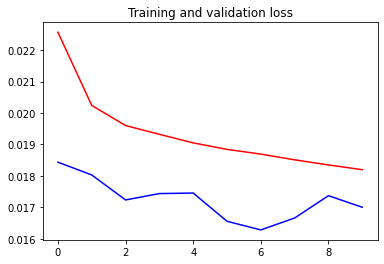

In [12]:
trHist = np.array([h.history['loss'],
                   h.history['val_loss']])

epochs = range(len(trHist[0])) # Get list of numbers in length of epochs

# Plot training and validation loss per epoch
plt.plot(epochs[0:100], trHist[0], 'r', label = "Training Loss")
plt.plot(epochs[0:100], trHist[1], 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.show()

In [13]:
vX, vY = loadDataset('Skogen7_2a2b_', dir = '../../Datasets/DVRUP_1f_2f2b/', selc = 'r')

In [14]:
#Reshape the dataset to the correct dimentions
vX = vX[:, :, :, 1:4] / 256
vY = vY[:, :, :] /256

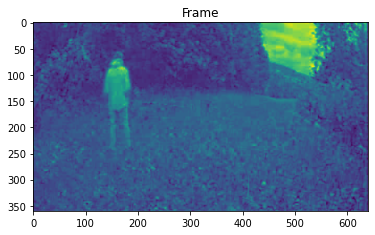

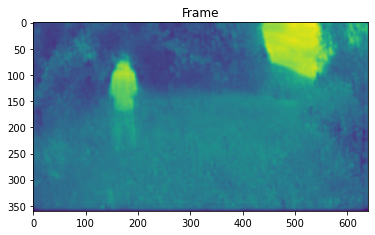

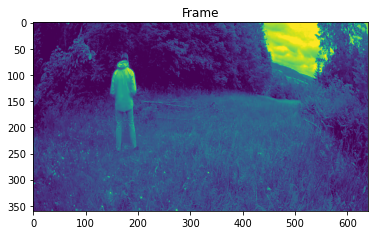

In [15]:
f = 500
valFrames = np.clip(autoencoder.predict(vX[f:f+1], batch_size = 1), 0.0, 1.0)
showFrame(vX[f, :, :, 2])
showFrame(valFrames[0, :, :, 0])
showFrame(vY[f, :, :, 0])

In [16]:
print('Processed: ')
print('Max: ', valFrames[0].max()  , '    Min:', valFrames[0].min()   , '    std: ', valFrames[0].std(),'          mean: ', valFrames[0].mean())
print('Input: ')
print('Max: ', vX[f, :, :, 0].max(), '    Min:', vX[f, :, :, 0].min() , '    std: ', vX[0].std(),' mean: ', vX[f, :, :, 0].mean())
print('Output: ')
print('Max: ', vY[f, :, :, 0].max(), '     Min:', vY[f, :, :, 0].min(), '    std: ', vY[0].std(),' mean: ', vY[f, :, :, 0].mean())

Processed: 
Max:  0.7578429     Min: 0.03881967     std:  0.1034158           mean:  0.33073735
Input: 
Max:  0.98828125     Min: 0.0     std:  0.10546864932898772  mean:  0.28413341946072046
Output: 
Max:  0.9921875      Min: 0.0     std:  0.12685316918077114  mean:  0.2252370876736111


In [17]:
#%tensorboard --logdir log_dir

In [18]:
comment = "Same as 119, but addition moved to second decoder layer"

In [19]:
outN = '120'
infoPath = '../TrainingResults/info/'
a = np.array([comment, parameters, datasetParams, modelGenParams, trHist], dtype = object)
np.save(infoPath + outN, a)

In [20]:
modPath = '../Models/'
autoencoder.save(modPath + outN +'.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [21]:
print(' Experiment',  outN, 'executed using tensorflow V', tf.__version__)

 Experiment 120 executed using tensorflow V 2.6.0-dev20210528


### Predicting the test video

In [22]:
%run ../Usage/DVRUP_IO.py
inVid = '../../Datasets/video/PICT0039.AVI'
outPath = '../../Datasets/video/output/'

In [23]:
inputVid = loadVideo(inVid, 100, 300, 0, 640, 60, 420)

In [24]:
r, g, b = reshapeAndSplitVideo(inputVid)
vid = processVideo(autoencoder, r, g, b, amp = 256)

Reshaped dataset to size:  (298, 360, 640, 3)
Reshaped dataset to size:  (298, 360, 640, 3)
Reshaped dataset to size:  (298, 360, 640, 3)
(298, 360, 640, 1) (298, 360, 640, 1) (298, 360, 640, 1)


In [25]:
saveVideo(vid, outPath + outN)

(298, 360, 640, 3)
